In [254]:
!curl "https://python-course.eu/data/mnist/mnist_train.csv" -o "mnist_train.csv"
!curl "https://python-course.eu/data/mnist/mnist_test.csv" -o "mnist_test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  104M    0  3230    0     0   3116      0  9:46:05  0:00:01  9:46:04  3120
  0  104M    0  829k    0     0   492k      0  0:03:37  0:00:01  0:03:36  493k
 14  104M   14 15.5M    0     0  5958k      0  0:00:17  0:00:02  0:00:15 5959k
 34  104M   34 36.1M    0     0  9989k      0  0:00:10  0:00:03  0:00:07 9990k
 52  104M   52 54.8M    0     0  11.6M      0  0:00:08  0:00:04  0:00:04 11.6M
 72  104M   72 75.5M    0     0  13.1M      0  0:00:07  0:00:05  0:00:02 16.0M
 91  104M   91 95.5M    0     0  14.3M      0  0:00:07  0:00:06  0:00:01 19.1M
100  104M  100  104M    0     0  14.9M      0  0:00:07  0:00:07 --:--:-- 20.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   T

In [255]:
# Read csv file
import csv
import numpy as np

with open('mnist_train.csv') as f:
    reader = csv.reader(f)
    train = np.array(list(reader)).astype('int')

print(train)
print(train.shape)
np.random.seed(0)
np.random.shuffle(train)
print(train)

with open('mnist_test.csv') as f:
    reader = csv.reader(f)
    test = np.array(list(reader)).astype('int')

print(test)
print(test.shape)
print(test)

[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]]
(60000, 785)
[[3 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]]
[[7 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [4 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]]
(10000, 785)
[[7 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [4 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]]


In [256]:
# Extract labels
train_labels = train[:, 0]
test_labels = test[:, 0]

# Extract features
train_features = train[:, 1:]
test_features = test[:, 1:]

# Normalize features
train_features = train_features / 255
test_features = test_features / 255

# One-hot encode labels
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

print(test_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [412]:
import importlib, os
import nn
importlib.reload(nn)

# Folder to save models
folder = 'models'

# Train neural networks
models = []
for x in range(10):


    layers = [
        nn.LinearLayer(784, 100, False),
        nn.ReLuLayer(),
        nn.LinearLayer(100, 100, False),
        nn.DropoutLayer(0.1),
        nn.ReLuLayer(),
        nn.LinearLayer(100, 10, False),
        nn.SoftmaxLayer()
    ]
    if os.path.exists(f'{folder}/model_{x}.pkl'):
        models.append(nn.load_model(f'{folder}/model_{x}.pkl'))
        print(f'Loaded model {x} from file')
    else:
        models.append(nn.NeuralNetwork(layers, 784, 10))
        models[x].train(train_features, train_labels, 0.5, 800, 1000, test_features, test_labels)

        # Save model
        if not os.path.exists(folder):
            os.mkdir(folder)
        models[x].save(f'{folder}/model_{x}.pkl')
        print(f'Saved model {x} to file')
    

Loaded model 0 from file
Loaded model 1 from file
Loaded model 2 from file
Loaded model 3 from file
Loaded model 4 from file
Loaded model 5 from file
Loaded model 6 from file
Loaded model 7 from file
Loaded model 8 from file
Loaded model 9 from file


In [413]:
# Ensemble scores
print(nn.score_ensemble_mean(models, test_features, test_labels))
print(nn.score_ensemble_mode(models, test_features, test_labels))

0.9615
0.9603


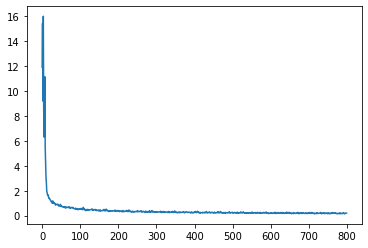

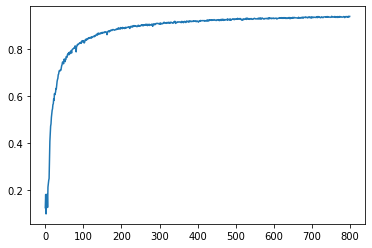

In [414]:
# Single model loss and accuracy
models[0].plot_loss()
models[0].plot_acc()

[7]


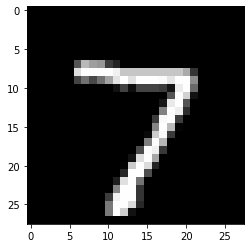

In [415]:
# Test prediction from an index
models[0].test_pred(0, test_features)